In [92]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 60, 15

In [2]:
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd

In [3]:

os.chdir("prepared_corpora/msrp_4/")

In [4]:
def embedding_distance(embeddings, id1, id2):
    ii = id1 - 1  #Change from 1 indexed id, to 0 indexex embedding index
    jj = id2 - 1
    return scipy.spatial.distance.cosine(embeddings[ii,:], embeddings[jj,:])

In [58]:

def load_links(link_filename):
    #return np.loadtxt(link_filename, delimiter=",",skiprows=0, dtype=np.int)
    import csv
    links = None
    with open(link_filename,"r") as fh:
        reader = csv.reader(fh)
        links  = [[int(ele) for ele in row] for row in reader]
    return links 

def load_link_distances(link_filename, embeddings):
    print(link_filename)
    links = load_links(link_filename)
    dists = pd.Series()
    
    for link in links:
        assert(len(link)==2)
        phrase_id = link[0]
        var_phrase_id = link[1]
        
        dists.loc[phrase_id] = embedding_distance(embeddings, phrase_id, var_phrase_id)
    return dists



In [54]:
linknames = "noun_sym verb_sym noun_random verb_random verb_anto".split()

def get_dists_table(embedding_filename, max_corruption = 10):
    embeddings = np.loadtxt(embedding_filename, delimiter=",")
    dists = pd.DataFrame()
    dists["paraphrase"] = load_link_distances("paraphrases.txt", embeddings)
    for corruption_level in range(1,max_corruption+1):
        for linkname in linknames:
            link_filename = str(corruption_level)+linkname+"_semantic_corruptions.txt"
            dists[linkname + "_" + str(corruption_level)] = load_link_distances(link_filename, embeddings)
        
    
    return dists.reindex_axis(sorted(dists.columns), axis=1)
    

In [97]:
def get_bow_dists_table(max_corruption = 10):
    from collections import Counter
    
    bows = [Counter(sent.split()) for sent in open("phrases.txt",'r')]
    
    def get_dist(linenum1, linenum2):
        from distance import jaccard
        bow1 = bows[linenum1-1]
        bow2 = bows[linenum2-1]
        keys = list(set(bow1.keys()).union(bow2.keys()))
        vec1 = [bow1[key] for key in  keys]
        vec2 = [bow2[key] for key in  keys]
        return scipy.spatial.distance.cosine(vec1,vec2)

    def get_dists(link_filename):
        dists = pd.Series()
        for link in load_links(link_filename):
            dists.loc[link[0]] = get_dist(link[0],link[1])
        return dists
        

    dists = pd.DataFrame()
    dists["paraphrase"] = get_dists("paraphrases.txt")
    for corruption_level in range(1,max_corruption+1):
        for linkname in linknames:
            link_filename = str(corruption_level)+linkname+"_semantic_corruptions.txt"
            dists[linkname + "_" + str(corruption_level)] = get_dists(link_filename)
        
    return dists.reindex_axis(sorted(dists.columns), axis=1)
    


In [99]:
bow_dists = get_bow_dists_table()
print( bow_dists.count())

noun_random_1     2362
noun_random_10      27
noun_random_2     2252
noun_random_3     1965
noun_random_4     1515
noun_random_5     1074
noun_random_6      684
noun_random_7      394
noun_random_8      199
noun_random_9       90
noun_sym_1        2102
noun_sym_10          0
noun_sym_2        1459
noun_sym_3         842
noun_sym_4         396
noun_sym_5         175
noun_sym_6          51
noun_sym_7          11
noun_sym_8           2
noun_sym_9           0
paraphrase        2380
verb_anto_1        760
verb_anto_10         0
verb_anto_2        107
verb_anto_3         15
verb_anto_4          1
verb_anto_5          0
verb_anto_6          0
verb_anto_7          0
verb_anto_8          0
verb_anto_9          0
verb_random_1     2298
verb_random_10       0
verb_random_2     1763
verb_random_3     1063
verb_random_4      476
verb_random_5      137
verb_random_6       29
verb_random_7        8
verb_random_8        0
verb_random_9        0
verb_sym_1        1957
verb_sym_10          0
verb_sym_2 

In [59]:
rae_dists = get_dists_table("outVectors_rae.csv")
#wiki_doc2vec_dists = get_dists_table("outVectors_wiki_doc2vec.csv")
#hansard_doc2vec_dists = get_dists_table("outVectors_hansard_doc2vec.csv")
#wiki_sentence_doc2vec_dists = get_dists_table("outVectors_wiki_sentence_doc2vec.csv")
pv_dm_dists = get_dists_table("outVectors_wiki_sentence_concat_pvdm.csv")
pv_dbow_dists = get_dists_table("outVectors_wiki_sentence_dbow.csv")
#random_dists = get_dists_table("outVectors_random.csv")

paraphrases.txt
1noun_sym_semantic_corruptions.txt
1verb_sym_semantic_corruptions.txt
1noun_random_semantic_corruptions.txt
1verb_random_semantic_corruptions.txt
1verb_anto_semantic_corruptions.txt
2noun_sym_semantic_corruptions.txt
2verb_sym_semantic_corruptions.txt
2noun_random_semantic_corruptions.txt
2verb_random_semantic_corruptions.txt
2verb_anto_semantic_corruptions.txt
3noun_sym_semantic_corruptions.txt
3verb_sym_semantic_corruptions.txt
3noun_random_semantic_corruptions.txt
3verb_random_semantic_corruptions.txt
3verb_anto_semantic_corruptions.txt
4noun_sym_semantic_corruptions.txt
4verb_sym_semantic_corruptions.txt
4noun_random_semantic_corruptions.txt
4verb_random_semantic_corruptions.txt
4verb_anto_semantic_corruptions.txt
5noun_sym_semantic_corruptions.txt
5verb_sym_semantic_corruptions.txt
5noun_random_semantic_corruptions.txt
5verb_random_semantic_corruptions.txt
5verb_anto_semantic_corruptions.txt
6noun_sym_semantic_corruptions.txt
6verb_sym_semantic_corruptions.txt
6nou

In [ ]:
for nchanges in range(1,10+1):
    verb_antos = bow_dists["verb_anto_"+str(nchanges)]
    noun_syms =  bow_dists["noun_sym_"+str(nchanges)]a
    valid_dists = bow_dists[np.logical_and(pd.notnull(verb_antos), pd.notnull(noun_syms))]
    print(nchanges, "\t", len(valid_dists))

In [ ]:
pd.options.display.float_format = None
bow_dists

In [106]:
def get_results_table(comparator_series_method, max_changes, **model_dists):
    
    res = pd.DataFrame()
    res["n_changes"] = list(range(1,max_changes+1))
    
    model_names = list(model_dists.keys())
    model_names.sort()
    model_names.reverse()
    for model_name in model_names:
        dists = model_dists[model_name]
        res[model_name] = comparator_series_method(dists,max_changes)
        #n_rel_than_paraphrase(prefix, dists, operation, max_changes)
    return res
        
    

def n_rel_than_paraphrase(prefix, dists, operation =lambda para_dist,var_dist: var_dist<para_dist, max_changes=10):
    """
    prefix : eg "verb_anto_" or  "noun_sym_"
    """

    return [operation(dists.paraphrase, dists[prefix+str(nchanges)]).sum()/dists[prefix+str(nchanges)].count() 
                 for nchanges in range(1,max_changes+1)]

def get_lt_para_table(prefix="noun_sym_", max_changes=9):
    def lt_para(dists,max_changes):
        return n_rel_than_paraphrase(prefix, dists, lambda para_dist,var_dist: var_dist<=para_dist, max_changes)
    return get_results_table(lt_para,max_changes,
                  URAE= rae_dists,
                  PVDM = pv_dm_dists,
                  PVDBOW = pv_dbow_dists,
                  BOW = bow_dists
                 )

def get_a_gt_b_table(a_prefix, b_prefix, max_changes):
    def a_gt_b(dists,max_changes):
        def inner():
            for nchanges in range(1,max_changes+1):
                noun_random = dists["noun_random_"+str(nchanges)]
                noun_syms =  dists["noun_sym_"+str(nchanges)]
                valid_dists = dists[np.logical_and(pd.notnull(noun_random), pd.notnull(noun_syms))]
                yield (noun_random > noun_syms).sum()/len(valid_dists)
        return list(inner())
    return get_results_table(a_gt_b,max_changes,
              URAE= rae_dists,
              PVDM = pv_dm_dists,
              PVDBOW = pv_dbow_dists,
              BOW = bow_dists
             )

In [107]:
pd.options.display.float_format = lambda x: '{:.0f}%'.format(x*100)


In [108]:
get_lt_para_table("noun_random_",9)

,n_changes,URAE,PVDM,PVDBOW,BOW
0,1,94%,93%,91%,100%
1,2,88%,81%,87%,99%
2,3,83%,71%,80%,95%
3,4,78%,61%,73%,86%
4,5,72%,52%,66%,71%
5,6,64%,45%,60%,55%
6,7,59%,44%,48%,41%
7,8,53%,34%,50%,34%
8,9,53%,32%,41%,26%


In [109]:
get_lt_para_table("verb_anto_",9)

,n_changes,URAE,PVDM,PVDBOW,BOW
0,1,97%,93%,90%,100%
1,2,93%,78%,83%,100%
2,3,87%,40%,80%,87%
3,4,100%,100%,0%,100%
4,5,nan%,nan%,nan%,nan%
5,6,nan%,nan%,nan%,nan%
6,7,nan%,nan%,nan%,nan%
7,8,nan%,nan%,nan%,nan%
8,9,nan%,nan%,nan%,nan%


In [110]:
get_lt_para_table("verb_sym_",9)

,n_changes,URAE,PVDM,PVDBOW,BOW
0,1,95%,95%,90%,100%
1,2,92%,85%,82%,99%
2,3,90%,77%,77%,94%
3,4,86%,69%,70%,89%
4,5,78%,65%,70%,61%
5,6,50%,50%,75%,50%
6,7,nan%,nan%,nan%,nan%
7,8,nan%,nan%,nan%,nan%
8,9,nan%,nan%,nan%,nan%


In [111]:
get_lt_para_table("verb_random_",9)

,n_changes,URAE,PVDM,PVDBOW,BOW
0,1,90%,94%,92%,100%
1,2,83%,83%,87%,99%
2,3,78%,73%,79%,94%
3,4,74%,62%,74%,83%
4,5,70%,51%,65%,64%
5,6,69%,41%,52%,38%
6,7,88%,88%,50%,25%
7,8,nan%,nan%,nan%,nan%
8,9,nan%,nan%,nan%,nan%


In [112]:
get_a_gt_b_table("noun_sym_","verb_sym_",9)

,n_changes,URAE,PVDM,PVDBOW,BOW
0,1,65%,50%,46%,3%
1,2,71%,49%,44%,6%
2,3,73%,50%,43%,6%
3,4,77%,49%,41%,6%
4,5,79%,53%,42%,6%
5,6,84%,55%,47%,12%
6,7,91%,73%,55%,18%
7,8,100%,50%,0%,0%
8,9,nan%,nan%,nan%,nan%


In [113]:
get_a_gt_b_table("verb_anto","verb_random_",9)

,n_changes,URAE,PVDM,PVDBOW,BOW
0,1,65%,50%,46%,3%
1,2,71%,49%,44%,6%
2,3,73%,50%,43%,6%
3,4,77%,49%,41%,6%
4,5,79%,53%,42%,6%
5,6,84%,55%,47%,12%
6,7,91%,73%,55%,18%
7,8,100%,50%,0%,0%
8,9,nan%,nan%,nan%,nan%


In [ ]:
def anto_eq_sym(dists,max_changes):
    def inner():
        for nchanges in range(1,max_changes+1):
            verb_antos = dists["verb_anto_"+str(nchanges)]
            noun_syms =  dists["noun_sym_"+str(nchanges)]
            valid_dists = dists[np.logical_and(pd.notnull(verb_antos), pd.notnull(noun_syms))]
            yield (verb_antos == noun_syms).sum()/len(valid_dists)
    return list(inner())

get_results_table(anto_eq_sym, 4,
                  URAE= rae_dists,
                  PVDM = pv_dm_dists,
                  PVDBOW = pv_dbow_dists,
                  BOW = bow_dists
                 )

In [88]:
def drop_null_cols(df):
    keep_cols = [col for col in df.columns if not(all(pd.isnull(df.loc[:,col])))]
    return df.loc[:,keep_cols]
    


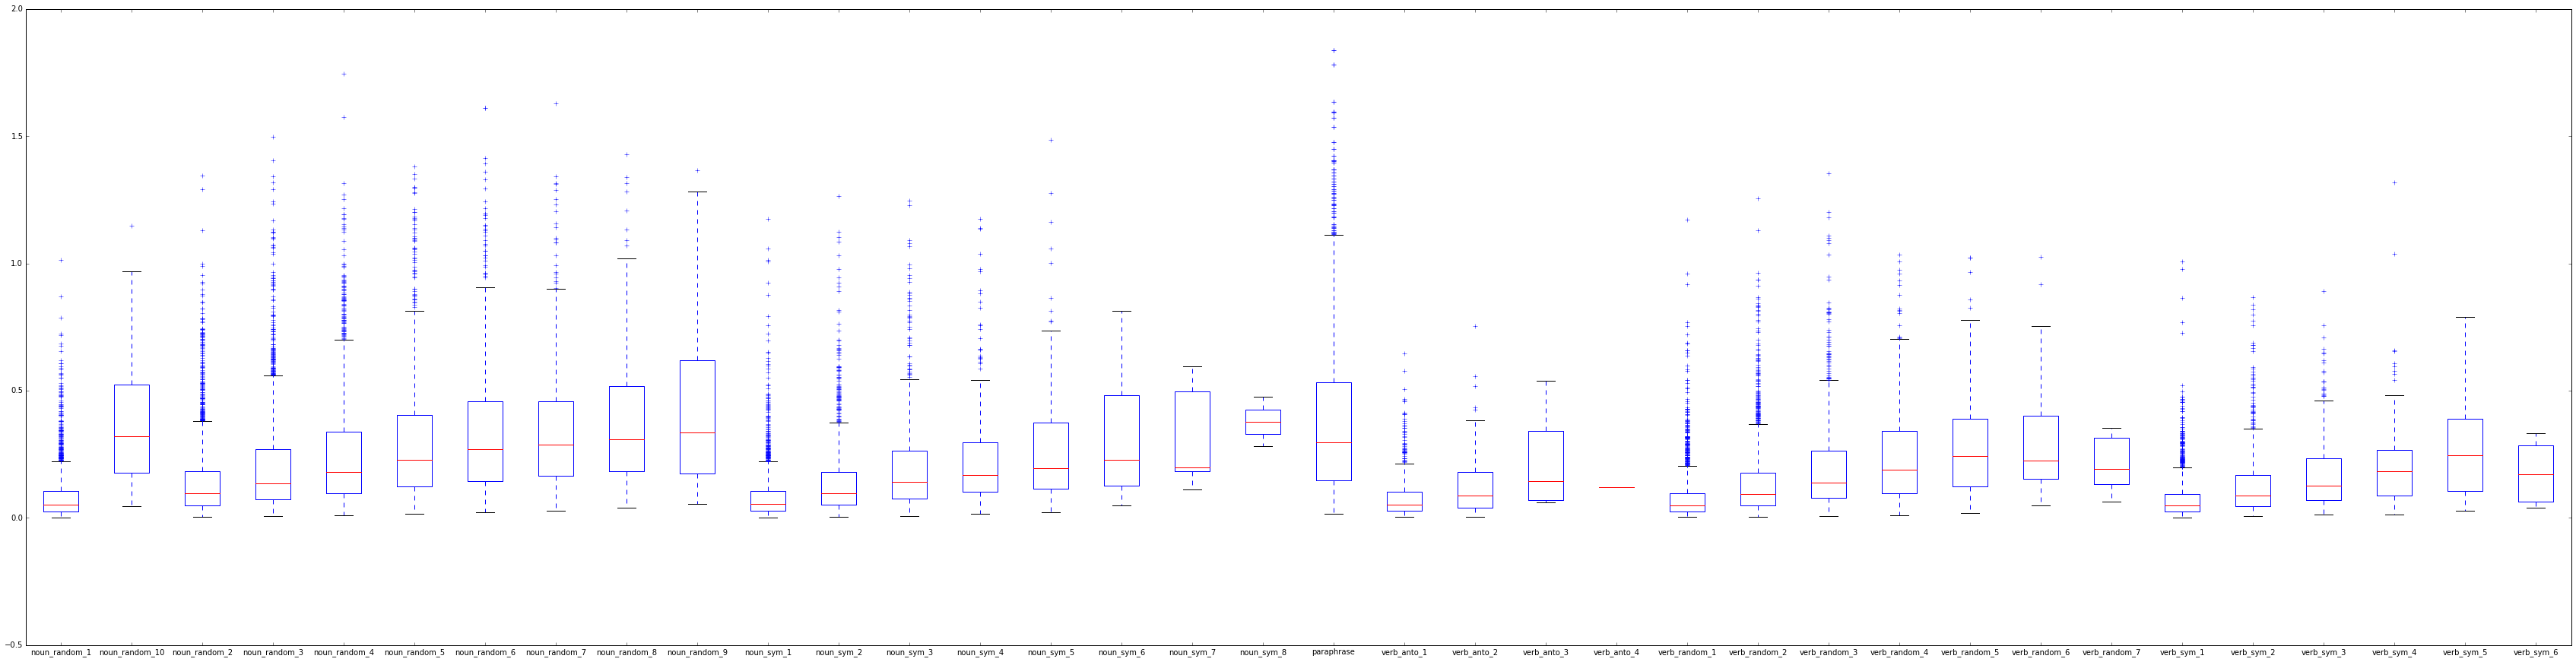

In [93]:
ax=drop_null_cols(pv_dm_dists).plot(kind="box", sort_columns=True)
ax.figure.savefig("figs/pv_dm_box.pdf")

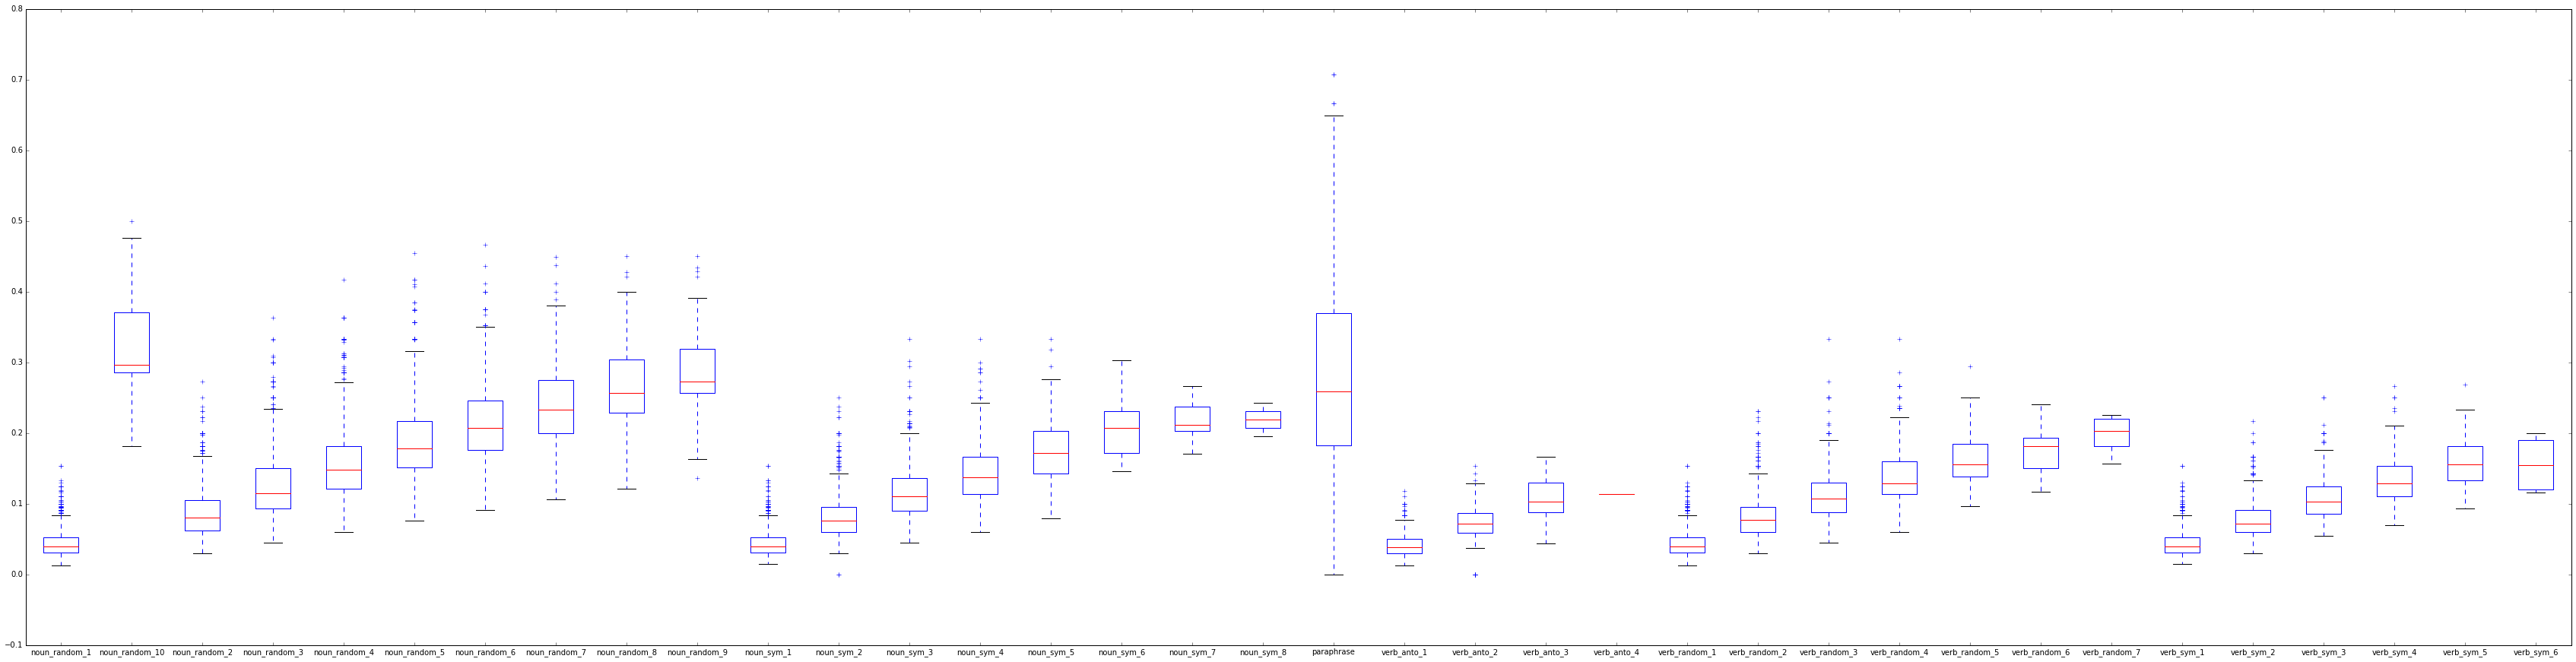

In [115]:
ax=drop_null_cols(bow_dists).plot(kind="box", sort_columns=True)
ax.figure.savefig("figs/bow_box.pdf")

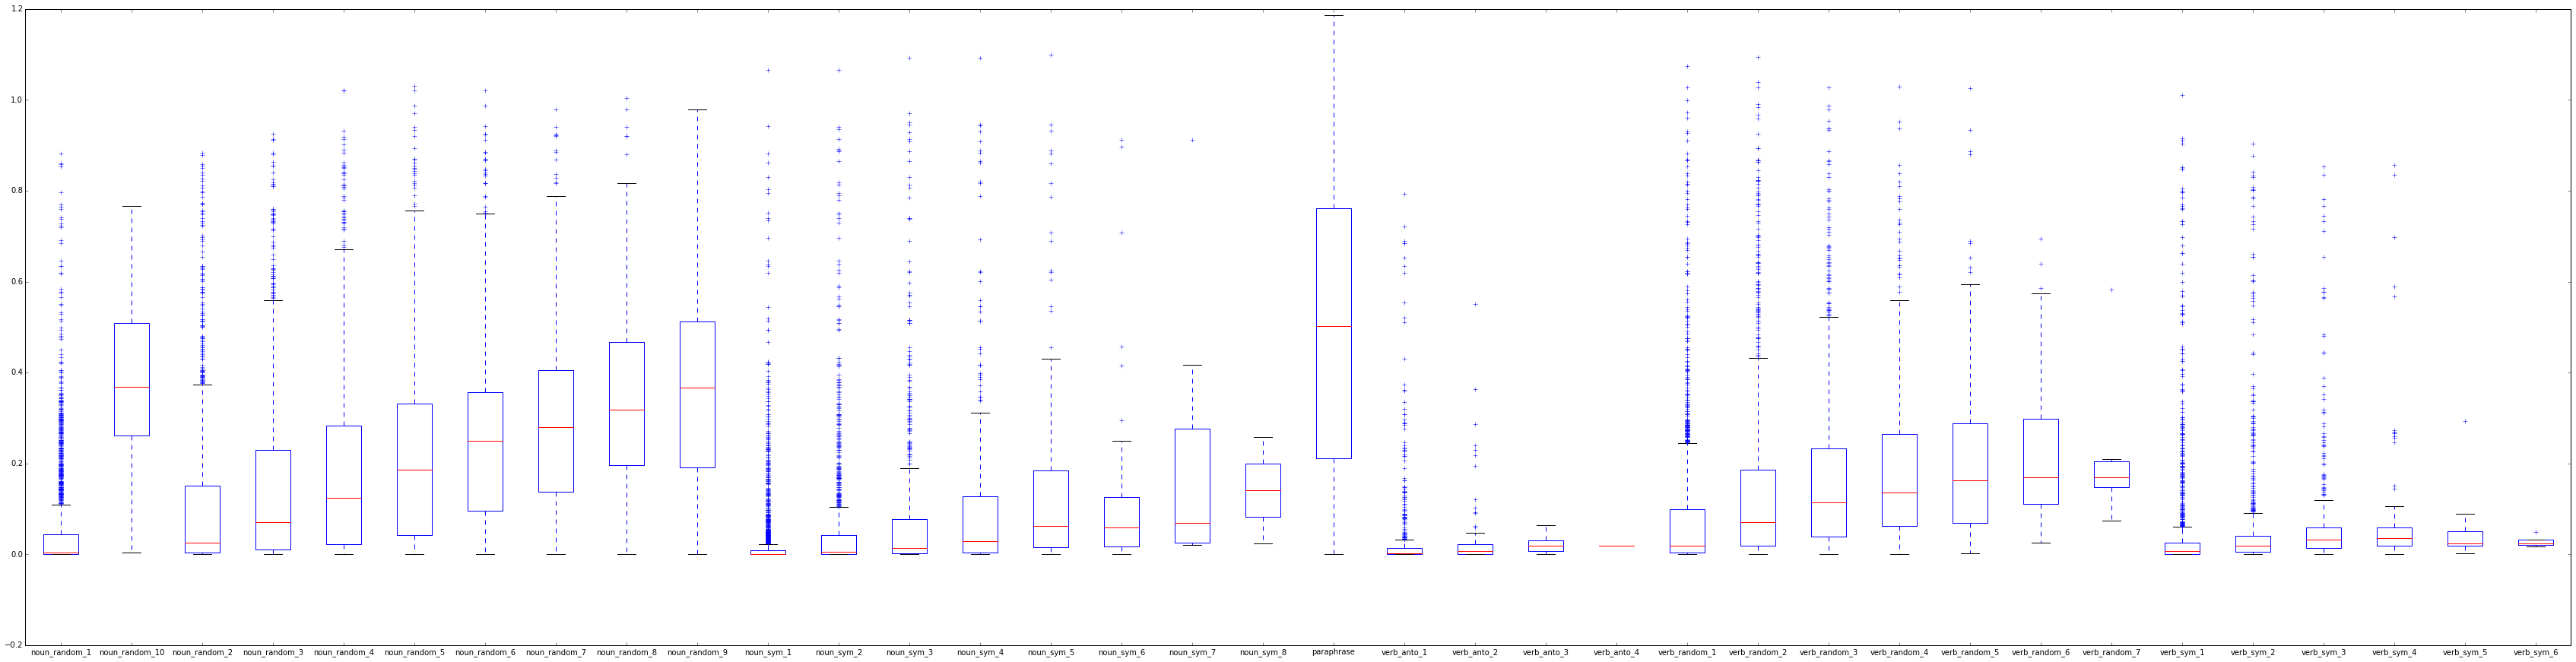

In [95]:
ax=drop_null_cols(rae_dists).plot(kind="box")
ax.figure.savefig("figs/rae_box.pdf")

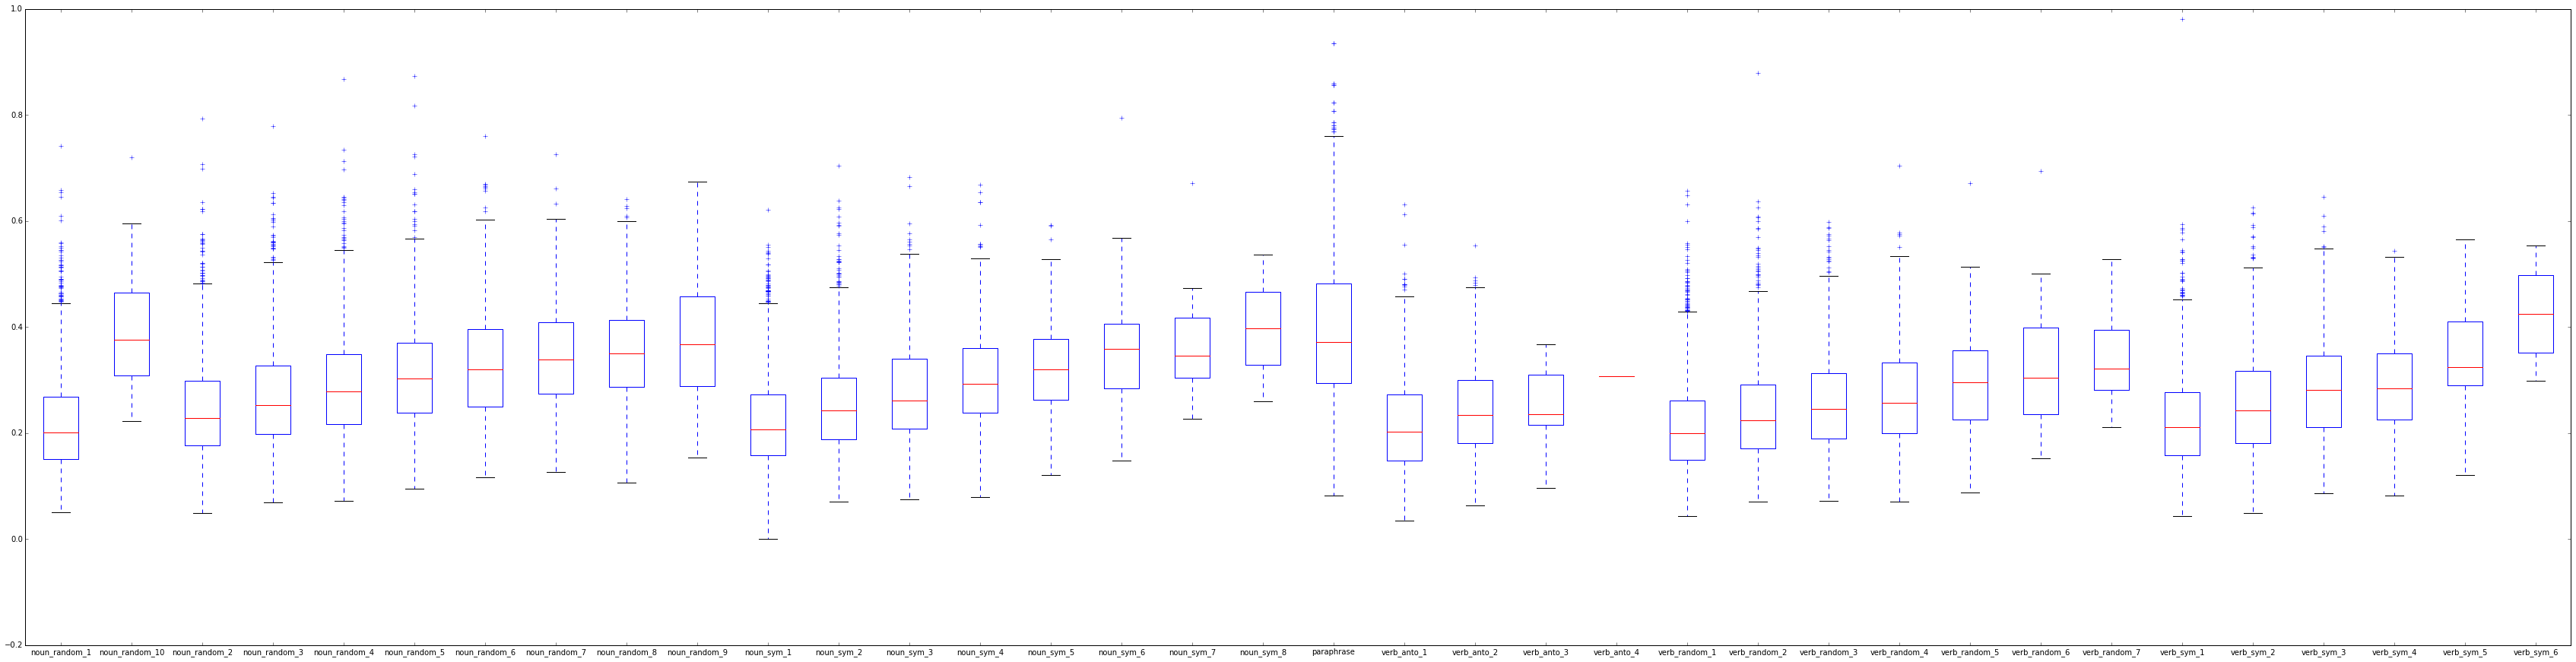

In [96]:
ax=drop_null_cols(pv_dbow_dists).plot(kind="box", sort_columns=True)
ax.figure.savefig("figs/pv_dbow_box.pdf")

In [ ]:
fig = pl.figure()

In [ ]:
def bhattacharyya(R,S, n_bins):
    dist_range = (0,2)
    bin_width = (dist_range[1]-dist_range[0])/n_bins
    
    R_hist = np.histogram(R, bins=n_bins, range=dist_range, density=True)[0] * bin_width
    S_hist = np.histogram(S, bins=n_bins, range=dist_range, density=True)[0] * bin_width
    
    return np.dot(np.sqrt(R_hist),np.sqrt(S_hist))
    

In [ ]:

raw_hist, _ = np.histogram(bow_dists.noun_sym_6, range=(0,2), normed=True)

In [ ]:
bhattacharyya(rae_dists.noun_sym_5, rae_dists.verb_anto_5,200000)

In [ ]:


def bhattacharyya_anto_sym(dists, max_changes):
    def inner():
        for nchanges in range(1,max_changes+1):
            verb_antos = dists["verb_anto_"+str(nchanges)]
            noun_syms =  dists["noun_sym_"+str(nchanges)]
            nbins = 10 # int(np.sqrt(min(verb_antos.count(), noun_syms.count())))
            yield bhattacharyya(noun_syms, verb_antos, nbins)
    return list(inner())

get_results_table(bhattacharyya_anto_sym, 4,
                  URAE= rae_dists,
                  PVDM = pv_dm_dists,
                  PVDBOW = pv_dbow_dists,
                  BOW = bow_dists
                 )

In [ ]:
def bhattacharyya_syn(dists, max_changes):
    def inner():
        paras = dists.paraphrase
        for nchanges in range(1,max_changes+1):
            noun_syms =  dists["noun_sym_"+str(nchanges)]
            nbins = 10# int(np.sqrt(noun_syms.count()))
            yield bhattacharyya(noun_syms, paras, nbins)
    return list(inner())

get_results_table(bhattacharyya_syn, 9,
                  URAE= rae_dists,
                  PVDM = pv_dm_dists,
                  PVDBOW = pv_dbow_dists,
                  BOW = bow_dists
                 )

In [ ]:
def bhattacharyya_anto(dists, max_changes):
    def inner():
        paras = dists.paraphrase
        for nchanges in range(1,max_changes+1):
            verb_antos = dists["verb_anto_"+str(nchanges)]
            nbins = 10# int(np.sqrt(verb_antos.count()))
            yield bhattacharyya(verb_antos, paras, nbins)
    return list(inner())

get_results_table(bhattacharyya_anto, 5,
                  URAE= rae_dists,
                  PVDM = pv_dm_dists,
                  PVDBOW = pv_dbow_dists,
                  BOW = bow_dists
                 )